## <center> Disease Prediction Using ML </center>

### Importing libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel

### Load datasets

In [29]:

symptoms_df = pd.read_csv(r"C:\Users\sonam\Downloads\symptoms_df.csv").drop(columns=['Unnamed: 0'], errors='ignore')
description_df = pd.read_csv(r"C:\Users\sonam\Downloads\description.csv")
medications_df = pd.read_csv(r"C:\Users\sonam\Downloads\medications.csv")
precautions_df = pd.read_csv(r"C:\Users\sonam\Downloads\precautions_df.csv").drop(columns=['Unnamed: 0'], errors='ignore')

### Data Exploration

In [30]:
print("Symptoms Dataset:")
print(symptoms_df.info())
print(symptoms_df.head())

print("Description Dataset:")
print(description_df.info())
print(description_df.head())

print("Medications Dataset:")
print(medications_df.info())
print(medications_df.head())

print("Precautions Dataset:")
print(precautions_df.info())
print(precautions_df.head())


symptoms_df.fillna("None", inplace=True)
description_df.fillna("None", inplace=True)
medications_df.fillna("None", inplace=True)
precautions_df.fillna("None", inplace=True)

Symptoms Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Disease    4920 non-null   object
 1   Symptom_1  4920 non-null   object
 2   Symptom_2  4920 non-null   object
 3   Symptom_3  4920 non-null   object
 4   Symptom_4  4572 non-null   object
dtypes: object(5)
memory usage: 192.3+ KB
None
            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4  
0   dischromic _patches  
1                

### Check for missing values

In [31]:
print("Missing values in Symptoms Dataset:")
print(symptoms_df.isnull().sum())

print("Missing values in Symptoms Dataset:")
print(description_df.isnull().sum())

print("Missing values in Symptoms Dataset:")
print(medications_df.isnull().sum())

print("Missing values in Precautions Dataset:")
print(precautions_df.isnull().sum())

Missing values in Symptoms Dataset:
Disease      0
Symptom_1    0
Symptom_2    0
Symptom_3    0
Symptom_4    0
dtype: int64
Missing values in Symptoms Dataset:
Disease        0
Description    0
dtype: int64
Missing values in Symptoms Dataset:
Disease       0
Medication    0
dtype: int64
Missing values in Precautions Dataset:
Disease         0
Precaution_1    0
Precaution_2    0
Precaution_3    0
Precaution_4    0
dtype: int64


### Correlation Analysis

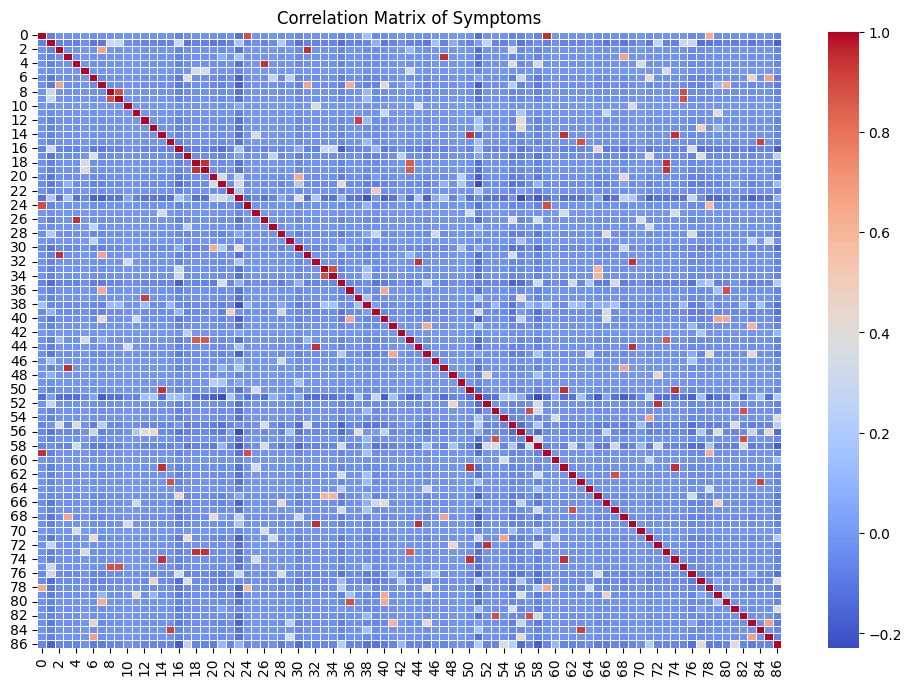

In [32]:

correlation_matrix = np.corrcoef(X.T)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Symptoms")
plt.show()

### Converting to lists

In [33]:
symptoms_df['Symptoms'] = symptoms_df.iloc[:, 1:].apply(lambda x: ','.join(x.values.astype(str)), axis=1)
symptoms_df = symptoms_df[['Disease', 'Symptoms']]

### Encode symptoms

In [34]:
symptom_set = set()
for symptoms in symptoms_df['Symptoms']:
    symptom_set.update(symptoms.split(','))

symptom_list = list(symptom_set)
symptom_encoding = {symptom: i for i, symptom in enumerate(symptom_list)}

def encode_symptoms(symptoms):
    vector = np.zeros(len(symptom_list))
    for symptom in symptoms.split(','):
        if symptom in symptom_encoding:
            vector[symptom_encoding[symptom]] = 1
    return vector

X = np.array(symptoms_df['Symptoms'].apply(encode_symptoms).tolist())
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(symptoms_df['Disease'])

### Train-test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Selection

In [36]:
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
selector = SelectFromModel(xgb, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print("X_train_selected shape:", X_train_selected.shape)
print("y_train shape:", y_train.shape)
print("Selected Features Shape:", X_train_selected.shape)

X_train_selected shape: (3936, 44)
y_train shape: (3936,)
Selected Features Shape: (3936, 44)


### Train models

In [37]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42)
}

accuracies = {}
conf_matrices = {}

for name, model in models.items():
    print(f"Training {name} model...")
    try:
        model.fit(X_train_selected, y_train)
        print(f"{name} training completed!")
        y_pred = model.predict(X_test_selected)
        print(f"Predictions for {name}: {y_pred[:10]}")
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[name] = accuracy
        conf_matrices[name] = confusion_matrix(y_test, y_pred)
        print(f"{name} Model Results:")
        print("Accuracy:", accuracy)
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", conf_matrices[name])
        print("-" * 50)
    except Exception as e:
        print(f"Error training {name}: {e}")

Training RandomForest model...
RandomForest training completed!
Predictions for RandomForest: [ 2  2 24  1  9 23 25  5 19 30]
RandomForest Model Results:
Accuracy: 0.9258130081300813
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        30
           2       0.92      1.00      0.96        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       0.55      1.00      0.71        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      0.87      0.93        15
          10       1.00      0.96      0.98        23
          11       1.00      0.92      0.96        26
          12       1.00      1.00      1.00        21
          13       1.00      0.90   

### Cross-validation scores

In [38]:
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5)
    print(f"{name} Cross-validation Accuracy:", np.mean(cv_scores))

RandomForest Cross-validation Accuracy: 0.9390240520127193
XGBoost Cross-validation Accuracy: 0.9392791491173188


### Accuracy Comparison Plot

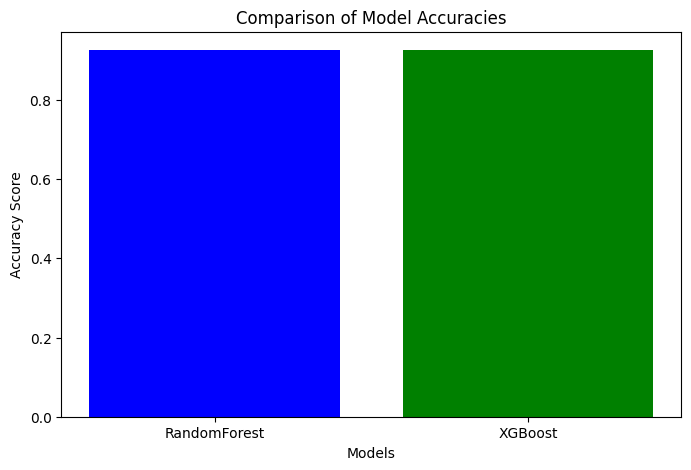

In [39]:

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green'])
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracies")
plt.show()

### Confusion Matrices Plot

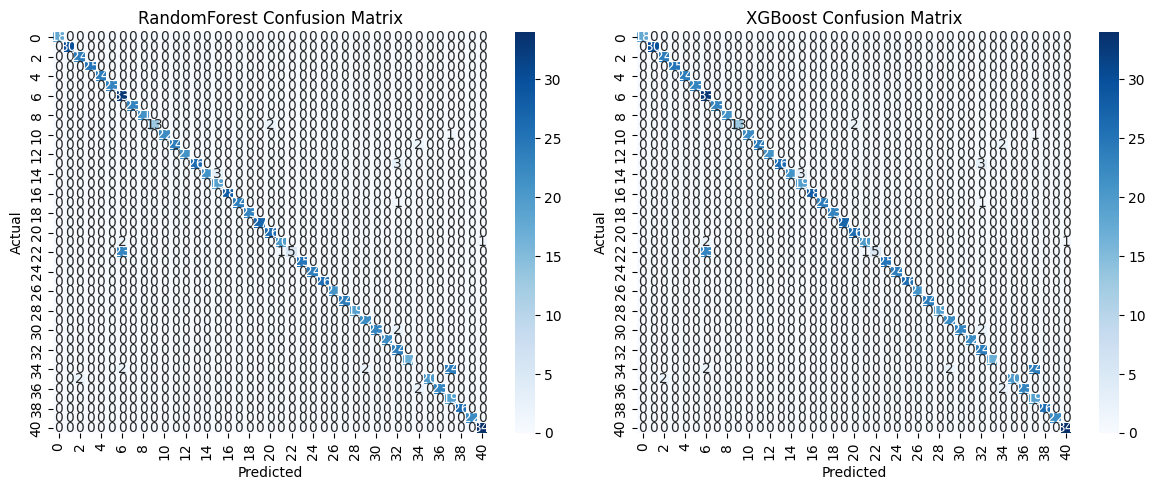

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, (name, matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")
plt.tight_layout()
plt.show()

### Prediction function

In [41]:
def predict_disease(symptoms, model_name="RandomForest"):
    symptoms_vector = encode_symptoms(','.join(symptoms))
    symptoms_vector = np.array(symptoms_vector).reshape(1, -1)
    symptoms_vector_selected = selector.transform(symptoms_vector)
    
    model = models[model_name]
    disease_index = model.predict(symptoms_vector_selected)[0]
    disease = label_encoder.inverse_transform([disease_index])[0]
    
    description = description_df[description_df['Disease'] == disease]['Description'].values[0]
    medications = medications_df[medications_df['Disease'] == disease]['Medication'].values[0]
    precautions = precautions_df[precautions_df['Disease'] == disease].iloc[:, 1:].values.flatten()
    
    return {
        "Disease": disease,
        "Description": description,
        "Medications": medications,
        "Precautions": [p for p in precautions if p != "None"]
    }

### Example usage

In [42]:
user_symptoms = ["itching", "skin_rash", "nodal_skin_eruptions"]
prediction = predict_disease(user_symptoms, model_name="XGBoost")
print(prediction)

{'Disease': 'Drug Reaction', 'Description': 'Drug Reaction occurs when the body reacts adversely to a medication.', 'Medications': "['Antihistamines', 'Epinephrine', 'Corticosteroids', 'Antibiotics', 'Antifungal Cream']", 'Precautions': ['stop irritation', 'consult nearest hospital', 'stop taking drug', 'follow up']}


### Data Visualization

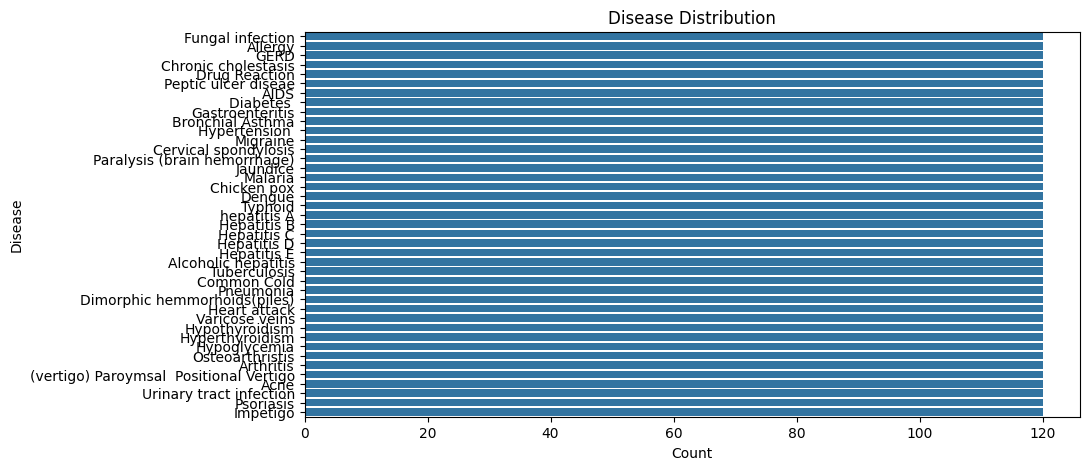

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(y=symptoms_df['Disease'], order=symptoms_df['Disease'].value_counts().index)
plt.title("Disease Distribution")
plt.xlabel("Count")
plt.ylabel("Disease")
plt.show()